In [1]:
import sys
sys.path.append("/scratch/gf332/BayesOpt/boa/scripts")

import os

import tensorflow as tf
import tensorflow_probability as tfp

from varz.tensorflow import Vars, minimise_l_bfgs_b, minimise_adam
from stheno.tensorflow import GP, EQ, Delta, Graph, Matern52
from stheno.tensorflow import Graph

import numpy as np
import matplotlib.pyplot as plt

from boa.models.fully_factorized_gp_v2 import FullyFactorizedGPModel
from boa.models.gp import GPModel
from boa.models.gpar_v2 import GPARModel
from boa.models.matrix_factorized_gpar_v2 import MatrixFactorizedGPARModel
from boa.models.gpar_perm import PermutedGPARModel

from boa.core.gp import GaussianProcess
from boa.core.utils import tf_bounded_variable

from boa.datasets.loader import load_dataset
from experiments_v2 import prepare_gpar_data

from sklearn.model_selection import train_test_split

In [2]:
# Set CPU as available physical device
tf.config.experimental.set_visible_devices([], 'GPU')

# Test Independent GP Model vs Reference Implementation

In [3]:
# Target function (noise free).
def f(X):
    return (np.sinc(3 * X) + 0.5 * (X - 0.5)**2).reshape(-1, 1)


# Generate X's and Y's for training.
np.random.seed(42)
X_train = np.array([
    -0.25,
    0,
    0.1,
]).reshape(-1, 1)
Y_train = f(X_train)

In [4]:
# Setup GP model and train.
model = GPModel(kernel='rbf', num_optimizer_restarts=3)
model.set_data(X_train, Y_train)
model.train()

model_v2 = FullyFactorizedGPModel(kernel='rbf', input_dim=1, output_dim=1, verbose=False)
model_v2.fit(X_train, Y_train, optimizer_restarts=3)

INFO:boa.models.fully_factorized_gp_v2:Dimension 0 Optimization round: 1 / 3
INFO:boa.models.fully_factorized_gp_v2:New best objective value for dimension 0: 4.1566
INFO:boa.models.fully_factorized_gp_v2:Dimension 0 Optimization round: 2 / 3
INFO:boa.models.fully_factorized_gp_v2:New best objective value for dimension 0: 4.1566
INFO:boa.models.fully_factorized_gp_v2:Dimension 0 Optimization round: 3 / 3
INFO:boa.models.fully_factorized_gp_v2:Loss for dimension 0: 4.1566


INFO:boa.models.fully_factorized_gp_v2:GPs haven't been cached yet, creating them now.


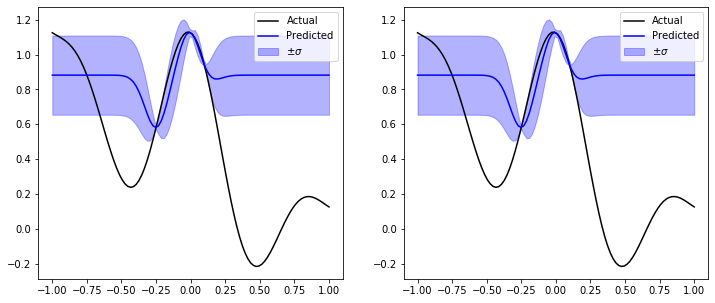

In [5]:
x_candidates = np.linspace(-1, 1, 100).reshape([-1, 1])

pred_mean, pred_var = model.predict_batch(x_candidates)

model_v2 = model_v2.condition_on(X_train, Y_train)
pred_mean_v2, pred_var_v2 = model_v2.predict(x_candidates)

pred_mean_v2 =  pred_mean_v2.numpy()
pred_var_v2 = pred_var_v2.numpy()

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, pred_mean, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (pred_mean + np.sqrt(pred_var)).T[0], (pred_mean - np.sqrt(pred_var)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.legend()

plt.subplot(122)
plt.plot(x_candidates, f(x_candidates), color='black', label="Actual")
plt.plot(x_candidates, pred_mean_v2, color='blue', label="Predicted")
plt.fill_between(x_candidates.T[0], (pred_mean_v2 + np.sqrt(pred_var_v2)).T[0], (pred_mean_v2 - np.sqrt(pred_var_v2)).T[0], color='blue', alpha=0.3, label=r"$\pm\sigma$")

plt.legend()

plt.show()

# Test GP, GPAR and MF-GPAR implementations in 1-D

In [3]:
# Test function
def f(x):
    return np.sinc(3 * x[:, 0]).reshape(-1, 1)

# Set seed for reproducibility
np.random.seed(42)

# Generate input data
x_train = np.random.rand(8, 2) * 2 - 1
pseudo_point = np.array([[0.8, 0.3]])
x_train = np.vstack([x_train, pseudo_point])

y_train = f(x_train)

# Points for plotting
x_cont = np.arange(-1.5, 1.5, 0.02).reshape(-1, 1)
x_cont = np.hstack([x_cont, x_cont])

In [5]:
# FF-GP model
ff_gp = FullyFactorizedGPModel(kernel='rbf', 
                               input_dim=2, 
                               output_dim=1, 
                               verbose=False, 
                               initialization_heuristic="random")

ff_gp.fit(x_train, y_train, optimizer_restarts=5)
ff_gp = ff_gp.condition_on(x_train, y_train)

y_pred_ff_gp, var_pred_ff_gp = ff_gp.predict(x_cont, numpy=True)

INFO:boa.models.fully_factorized_gp_v2:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.fully_factorized_gp_v2:Dimension 0 Optimization round: 1 / 5
INFO:boa.models.fully_factorized_gp_v2:New best objective value for dimension 0: 11.4002
INFO:boa.models.fully_factorized_gp_v2:Dimension 0 Optimization round: 2 / 5
INFO:boa.models.fully_factorized_gp_v2:Loss for dimension 0: 12.4640
INFO:boa.models.fully_factorized_gp_v2:Dimension 0 Optimization round: 3 / 5
INFO:boa.models.fully_factorized_gp_v2:Loss for dimension 0: 11.4002
INFO:boa.models.fully_factorized_gp_v2:Dimension 0 Optimization round: 4 / 5
INFO:boa.models.fully_factorized_gp_v2:Loss for dimension 0: 11.4002
INFO:boa.models.fully_factorized_gp_v2:Dimension 0 Optimization round: 5 / 5
INFO:boa.models.fully_factorized_gp_v2:Loss for dimension 0: 11.4002
INFO:boa.models.fully_factorized_gp_v2:GPs haven't been cached yet, creating them now.


In [6]:
# GPAR model
gpar = GPARModel(kernel='rbf', 
                 input_dim=2, 
                 output_dim=1, 
                 verbose=False, 
                 denoising=False,
                 initialization_heuristic="random")

gpar.fit(x_train, y_train, optimizer_restarts=5, optimizer="adam", trace=False, rate=1e-1)
gpar = gpar.condition_on(x_train, y_train)

y_pred_gpar, var_pred_gpar = gpar.predict(x_cont, numpy=True)

INFO:boa.models.gpar_v2:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
DEBUG:boa.models.gpar_v2:Creating hyperparameters!
INFO:boa.models.gpar_v2:Output 0, Iteration 1: New best loss: 11.403
INFO:boa.models.gpar_v2:Output 0, Iteration 2: Loss: 12.599
INFO:boa.models.gpar_v2:Output 0, Iteration 3: Loss: 12.599
INFO:boa.models.gpar_v2:Output 0, Iteration 4: New best loss: 11.402
INFO:boa.models.gpar_v2:Output 0, Iteration 5: Loss: 12.599
INFO:boa.models.gpar_v2:GPs haven't been cached yet, creating them now.


In [7]:
mf_gpar = MatrixFactorizedGPARModel(kernel='rbf', 
                                    latent_dim=1,
                                    input_dim=2, 
                                    output_dim=1, 
                                    verbose=False, 
                                    initialization_heuristic="median")

mf_gpar = mf_gpar.condition_on(x_train, y_train)
mf_gpar.fit_to_conditioning_data(optimizer_restarts=5, optimizer="l-bfgs-b", trace=False)

#mf_gpar.add_pseudo_point(pseudo_point)
y_pred_mf_gpar, var_pred_mf_gpar = mf_gpar.predict(x_cont, numpy=True)

INFO:boa.models.matrix_factorized_gpar_v2:Training data supplied with xs shape (9, 2) and ys shape (9, 1), training!
INFO:boa.models.gpar_v2:GPs haven't been cached yet, creating them now.


In [4]:
pgpar = PermutedGPARModel(kernel='rbf', 
                         input_dim=2, 
                         output_dim=1, 
                         verbose=False, 
                         denoising=False,
                         initialization_heuristic="random")

pgpar.fit(x_train, y_train, optimizer_restarts=5, learn_rate=1e-1, iters=1000)
pgpar = pgpar.condition_on(x_train, y_train)

y_pred_pgpar, var_pred_pgpar = pgpar.predict(x_cont, numpy=True)

Loss at iteration 259: 12.601:  26%|██▌       | 255/1000 [00:04<00:12, 60.27it/s]
INFO:boa.models.gpar_perm:Output 0, Iteration 1: New best loss: 12.601
Loss at iteration 999: 11.402: 100%|██████████| 1000/1000 [00:16<00:00, 60.97it/s]
INFO:boa.models.gpar_perm:Output 0, Iteration 2: New best loss: 11.402
Loss at iteration 312: 12.599:  31%|███       | 309/1000 [00:05<00:11, 60.15it/s]
INFO:boa.models.gpar_perm:Output 0, Iteration 3: Loss: 12.599
Loss at iteration 177: 12.600:  18%|█▊        | 176/1000 [00:02<00:13, 59.26it/s]
INFO:boa.models.gpar_perm:Output 0, Iteration 4: Loss: 12.600
Loss at iteration 999: 11.401: 100%|██████████| 1000/1000 [00:16<00:00, 60.19it/s]
INFO:boa.models.gpar_perm:Output 0, Iteration 5: New best loss: 11.401
INFO:boa.models.gpar_v2:GPs haven't been cached yet, creating them now.


 /scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


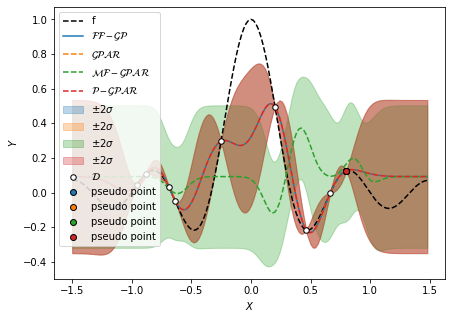

In [8]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

# Ground truth
ax.plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax.plot(x_cont[:, 0], y_pred_ff_gp, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax.fill_between(x_cont.T[0],
                (y_pred_ff_gp + 2 * np.sqrt(var_pred_ff_gp)).T[0],
                (y_pred_ff_gp - 2 * np.sqrt(var_pred_ff_gp)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# GPAR predictions
ax.plot(x_cont[:, 0], y_pred_gpar, color='C1', zorder=-1, label=r'$\mathcal{GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_gpar + 2 * np.sqrt(var_pred_gpar)).T[0],
                (y_pred_gpar - 2 * np.sqrt(var_pred_gpar)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# # # MF-GPAR predictions
ax.plot(x_cont[:, 0], y_pred_mf_gpar, color='C2', zorder=-1, label=r'$\mathcal{MF-GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_mf_gpar + 2 * np.sqrt(var_pred_mf_gpar)).T[0],
                (y_pred_mf_gpar - 2 * np.sqrt(var_pred_mf_gpar)).T[0],
                color='C2',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# PGPAR predictions
ax.plot(x_cont[:, 0], y_pred_pgpar, color='C3', zorder=-1, label=r'$\mathcal{P-GPAR}$', linestyle='dashed')
ax.fill_between(x_cont.T[0],
                (y_pred_pgpar + 2 * np.sqrt(var_pred_pgpar)).T[0],
                (y_pred_pgpar - 2 * np.sqrt(var_pred_pgpar)).T[0],
                color='C3',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# Data points
ax.scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax.scatter(x=pseudo_point[:, 0], y=ff_gp.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=gpar.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=mf_gpar.predict(pseudo_point)[0][0], c='C2', edgecolors='black', label='pseudo point')
ax.scatter(x=pseudo_point[:, 0], y=pgpar.predict(pseudo_point)[0][0], c='C3', edgecolors='black', label='pseudo point')

ax.legend(loc='upper left')
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')

fig.show()

# Test saving

In [30]:
ff_gp_save_path = "models/ff_gp/gp1"

ff_gp.save(ff_gp_save_path)

ff_gp_ = FullyFactorizedGPModel.restore(ff_gp_save_path)

y_pred_ff_gp_, var_pred_ff_gp_ = ff_gp_.predict(x_cont)

y_pred_ff_gp_ = y_pred_ff_gp_.numpy()
var_pred_ff_gp_ = var_pred_ff_gp_.numpy()

gpar_save_path = "models/gpar/gp1"

gpar.save(gpar_save_path)

gpar_ = GPARModel.restore(gpar_save_path)

y_pred_gpar_, var_pred_gpar_ = gpar_.predict(x_cont)

y_pred_gpar_ = y_pred_gpar_.numpy()
var_pred_gpar_ = var_pred_gpar_.numpy()

DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True


DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
DEBUG:boa.core.gp:Predicted variance was stheno.matrix.Dense, not tf.Tensor. latent: False, jitter: True
 /scratch/gf332/BayesOpt/tf2-boa-venv/lib/python3.6/site-packages/ipykernel_launcher.py:69: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


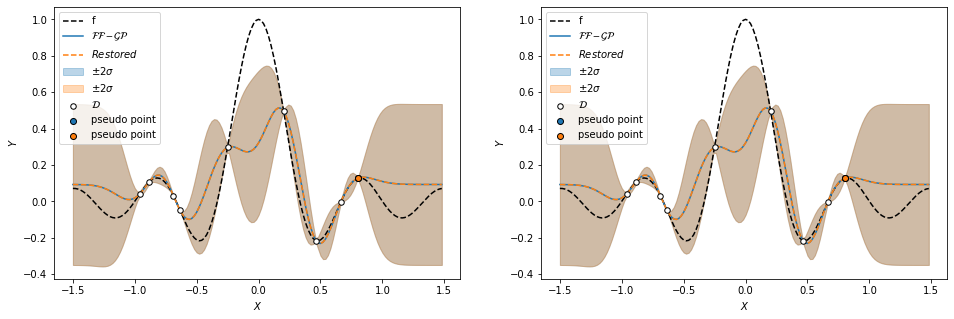

In [31]:
# Plot results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 5))

# Ground truth
ax[0].plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax[0].plot(x_cont[:, 0], y_pred_ff_gp, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax[0].fill_between(x_cont.T[0],
                (y_pred_ff_gp + 2 * np.sqrt(var_pred_ff_gp)).T[0],
                (y_pred_ff_gp - 2 * np.sqrt(var_pred_ff_gp)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# Restored predictions
ax[0].plot(x_cont[:, 0], y_pred_ff_gp_, color='C1', zorder=-1, label=r'$Restored$', linestyle='dashed')
ax[0].fill_between(x_cont.T[0],
                (y_pred_ff_gp_ + 2 * np.sqrt(var_pred_ff_gp_)).T[0],
                (y_pred_ff_gp_ - 2 * np.sqrt(var_pred_ff_gp_)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

ax[0].scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax[0].scatter(x=pseudo_point[:, 0], y=ff_gp.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax[0].scatter(x=pseudo_point[:, 0], y=ff_gp_.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')

ax[0].legend(loc='upper left')
ax[0].set_xlabel('$X$')
ax[0].set_ylabel('$Y$')

# ------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------

# Ground truth
ax[1].plot(x_cont[:, 0], f(x_cont), color='black', linestyle='dashed', label='f', zorder=-1)

# FF-GP predictions
ax[1].plot(x_cont[:, 0], y_pred_gpar, color='C0', zorder=-1, label=r'$\mathcal{FF-GP}$')
ax[1].fill_between(x_cont.T[0],
                (y_pred_gpar + 2 * np.sqrt(var_pred_gpar)).T[0],
                (y_pred_gpar - 2 * np.sqrt(var_pred_gpar)).T[0],
                color='C0',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

# GPAR predictions
ax[1].plot(x_cont[:, 0], y_pred_gpar_, color='C1', zorder=-1, label=r'$Restored$', linestyle='dashed')
ax[1].fill_between(x_cont.T[0],
                (y_pred_gpar_ + 2 * np.sqrt(var_pred_gpar_)).T[0],
                (y_pred_gpar_ - 2 * np.sqrt(var_pred_gpar_)).T[0],
                color='C1',
                alpha=0.3,
                zorder=-1,
                label=r'$\pm2\sigma$')

ax[1].scatter(x=x_train[:, 0], y=y_train[:, 0], s=30, c='white', edgecolors='black', label=r'$\mathcal{D}$')
ax[1].scatter(x=pseudo_point[:, 0], y=gpar.predict(pseudo_point)[0][0], c='C0', edgecolors='black', label='pseudo point')
ax[1].scatter(x=pseudo_point[:, 0], y=gpar_.predict(pseudo_point)[0][0], c='C1', edgecolors='black', label='pseudo point')

ax[1].legend(loc='upper left')
ax[1].set_xlabel('$X$')
ax[1].set_ylabel('$Y$')

fig.show()

In [6]:
x = tf.Variable(1.)